## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [2]:
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [16]:
df = pd.read_csv("data/train.csv",index_col=0)
df = df.dropna(axis=0)
print(df.describe())
y = df['is_duplicate']
X = df.drop('is_duplicate',axis=1)
y.index = X.index

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=.75,random_state=1738)

                qid1           qid2   is_duplicate
count  404287.000000  404287.000000  404287.000000
mean   217243.151093  220955.212082       0.369201
std    157751.614317  159903.168488       0.482589
min         1.000000       2.000000       0.000000
25%     74436.500000   74726.500000       0.000000
50%    192181.000000  197053.000000       0.000000
75%    346573.000000  354692.000000       1.000000
max    537932.000000  537933.000000       1.000000


### Exploration

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

X_train['question1'].map(lambda x: len(x.split(" "))).describe()

count    303215.000000
mean         10.948353
std           5.436659
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         125.000000
Name: question1, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb65bf44730>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb65bf44cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb65bf44460>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb65bf39310>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb65bf395e0>],
 'means': []}

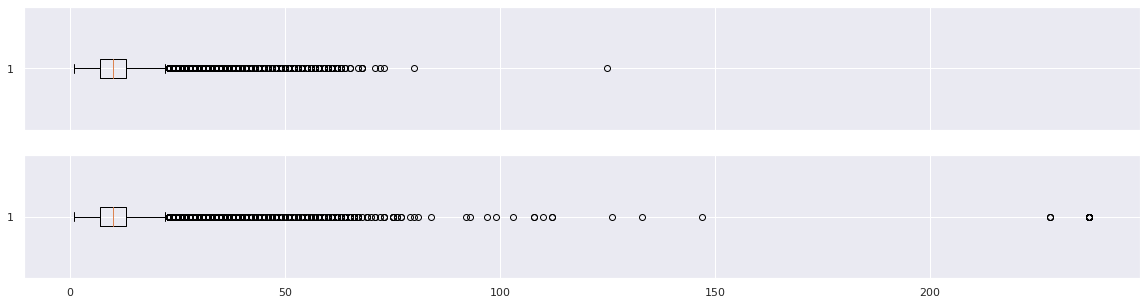

In [26]:
_, (ax1,ax2) = plt.subplots(2,1,sharex='all',figsize=(20,5))
ax1.boxplot(X_train['question1'].map(lambda x: len(x.split())), vert=False)
ax2.boxplot(X_train['question2'].map(lambda x: len(x.split())),vert=False)



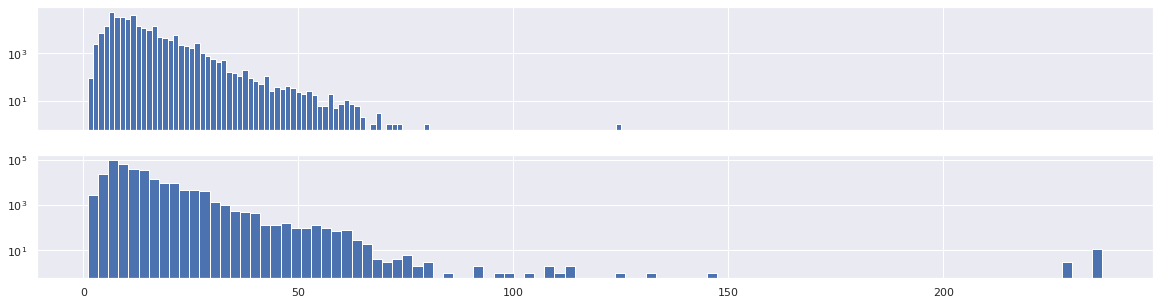

In [41]:
_, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(20,5));
ax1.hist(X_train['question1'].map(lambda x: len(x.split())),bins=100, log=True);
ax2.hist(X_train['question2'].map(lambda x: len(x.split())),bins=100, log=True);

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc